In [141]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import seaborn as sns
import pandas as pd
import io
import base64

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import tqdm 

import time

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 07: Redução de dimensionalidade

**1.** Considere o conjunto de dados disponível em penguins.csv, organizado em 5
colunas, sendo 4 colunas de atributos e a última a classe do padrão. Os dados
referem-se a medições anatômicas de pinguins da Antártida, classificados nas
espécies Adelie, Chinstrap e Gentoo. Maiores detalhes sobre os dados podem
ser conferidos em https://allisonhorst.github.io/palmerpenguins/.

Apresente a projeção em 2 dimensões dos padrões acima obtida pelo método PCA (análise dos componentes principais).

Ainda considerando o item anterior, calcule e mostre a variância explicada
obtida quando a dimensão projetada é modificada (1,2,3 ou 4).

Normalize os dados antes de executar PCA. Implemente sua própria versão de PCA, mas verifique a corretude comparando contra alguma implementação popular (e.g., da biblioteca scikitlearn).

**Steps:**

1. Feature standardization: mean = 0, std = 1
2. Obtain covariance matrix
3. Obtain eigenvalues and eigenvectors of covariance matrix
4. Sort eigenvalues in descending order and choose the k eigenvectors that correspond to the k largest eigenvalues (k = number of dimensions of the new feature subspace (k <= d))

Vamos definir uma função para aplicar o PCA:

In [142]:
def pca(n_components = 2):    

    data = pd.read_csv('penguins.csv', header = None)

    covariables = data.iloc[:, 0:4]
    target = data.iloc[:, 4]

    if n_components > covariables.shape[1]:
        # raise exception
        raise Exception('n_components cannot be greater than the number of covariables')
    
    else:
        # standardize data
        covariables = (covariables - covariables.mean()) / covariables.std()

        # get covariance matrix
        cov = covariables.cov()

        # get eigenvalues and eigenvectors
        eigvals, eigvecs = np.linalg.eig(cov)

        # sort eigenvalues and eigenvectors
        idx = eigvals.argsort()[::-1]
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:,idx]

        # get 2 PCA components, i.e. the 2 eigenvectors with the highest eigenvalues
        pca = eigvecs[:, 0:n_components] # projection matrix

        # reduce data to 2 dimensions
        covariables = np.dot(covariables, pca)

        # concatenate with target
        penguins_reduced = np.concatenate((covariables, np.array(target).reshape(-1, 1)), axis = 1)

        colnames = []
        for i in range(covariables.shape[1]):
            colnames.append('PC' + str(i + 1))

        colnames.append('Species')

        # dataframe
        penguins_reduced = pd.DataFrame(penguins_reduced, columns = colnames)

        # species is categorical
        penguins_reduced['Species'] = penguins_reduced['Species'].astype('category')

        return penguins_reduced, eigvals

Aplicando o PCA com `n_components=2`, conseguimos obter o seguinte resultado:

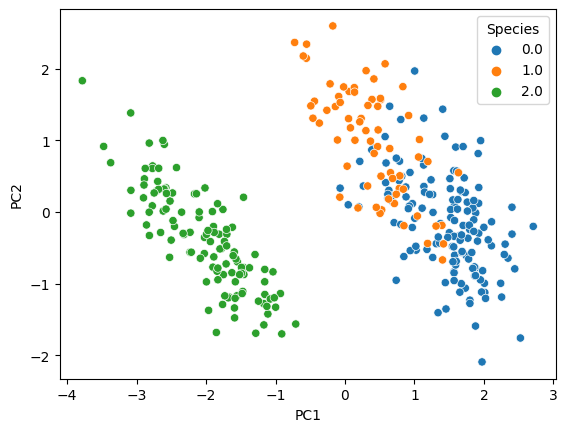

In [143]:
penguins_reduced, eigvals = pca(n_components = 2)

sns.scatterplot(penguins_reduced, x='PC1', y='PC2', hue='Species')
plt.show()

Agora, calculando a variância explicada para cada componente, observamos que, de fato, a primeira componente explica a maior parte da variância dos dados. Naturalmente, a segunda componente explica a segunda maior parte da variância dos dados e assim por diante.

In [144]:
# calculate variance explained
variance_explained = eigvals / eigvals.sum()

print("MY IMPLEMENTATION OF PCA")
print("-------------------")

print("Variance explained by...")
for i in range(len(variance_explained)):
    print("component {i}: {variance_explained}".format(i = i + 1, variance_explained = variance_explained[i]))

print("-------------------")

print("Variance explained by the first...")
for i in range(len(variance_explained)):
    print("{i} principal components: {variance_explained}".format(i = i + 1, variance_explained = variance_explained[0:i+1].sum()))

print("-------------------")

MY IMPLEMENTATION OF PCA
-------------------
Variance explained by...
component 1: 0.6863389313599902
component 2: 0.19452929284500153
component 3: 0.09216062988088344
component 4: 0.026971145914124795
-------------------
Variance explained by the first...
1 principal components: 0.6863389313599902
2 principal components: 0.8808682242049918
3 principal components: 0.9730288540858752
4 principal components: 1.0
-------------------


Agora, vamos comparar nosso resultado a uma implementação popular, a do scikit-learn:

In [145]:
penguins = pd.read_csv("penguins.csv", header = None)

penguinsCovariables = penguins.iloc[:, 0:4]
penguinsTarget = penguins.iloc[:, 4]

# standardize data
penguinsCovariables = (penguinsCovariables - penguinsCovariables.mean()) / penguinsCovariables.std()

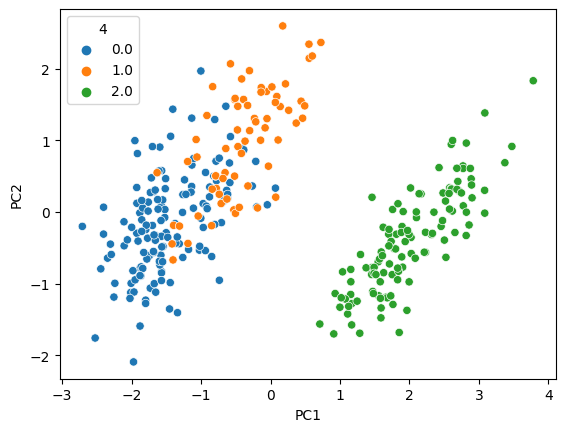

In [146]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca.fit(penguinsCovariables)

# apply PCA
pca_sklearn = pca.transform(penguinsCovariables)

# concatenate with target
pca_sklearn = np.concatenate((pca_sklearn, np.array(penguinsTarget).reshape(-1, 1)), axis = 1)

# dataframe
pca_sklearn = pd.DataFrame(pca_sklearn, columns = ['PC1', 'PC2', 4])
pca_sklearn[4] = pca_sklearn[4].astype('category')

# plot
sns.scatterplot(pca_sklearn, x='PC1', y='PC2', hue=4)
plt.show()

In [147]:
pca = PCA(n_components = 4)
pca.fit(penguinsCovariables)

# apply PCA
pca_sklearn = pca.transform(penguinsCovariables)

# get variance explained
variance_explained = pca.explained_variance_ratio_

print("sklearn IMPLEMENTATION OF PCA")
print("-------------------")

print("Variance explained by...")
for i in range(len(variance_explained)):
    print("component {i}: {variance_explained}".format(i = i + 1, variance_explained = variance_explained[i]))

print("-------------------")

print("Variance explained by the first...")
for i in range(len(variance_explained)):
    print("{i} principal components: {variance_explained}".format(i = i + 1, variance_explained = variance_explained[0:i+1].sum()))

print("-------------------")

sklearn IMPLEMENTATION OF PCA
-------------------
Variance explained by...
component 1: 0.6863389313599906
component 2: 0.1945292928450015
component 3: 0.09216062988088317
component 4: 0.026971145914124726
-------------------
Variance explained by the first...
1 principal components: 0.6863389313599906
2 principal components: 0.8808682242049921
3 principal components: 0.9730288540858752
4 principal components: 1.0
-------------------


Efetivamente, os resultados são os mesmos. Isso mostra que a nossa implementação está correta.

---

**2.** Implemente um autoencoder determinísitco para o banco de dados MNIST, que já usamos em exercícios anteriores. Você pode escolher utilizar tanto CNN como MLP no encoder/decoder. No entanto, o encoder deve mapear as imagens no $\mathbb{R}^2$, para podermos visualizar as representações latentes no plano. Use o conjunto de validação para fazer early stopping. Você também pode monitorar o erro na validação para anelar a taxa de aprendizado (usando um scheduler). Finalmente, mostre a projeção das imagens de teste no espaço latente e comente qualitativamente os embeddings obtidos.

In [148]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Vamos acessar os dados do MNIST:

In [149]:
# import the data
trainData = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testData = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# split the data into train and validation
trainData, valData = random_split(trainData, [0.7, 0.3])

# create dataloaders
trainLoader = DataLoader(trainData, batch_size=64, shuffle=True)
valLoader = DataLoader(valData, batch_size=64, shuffle=True)
testLoader = DataLoader(testData, batch_size=64, shuffle=True)

Vamos criar uma rede neural simples para o autoencoder:

In [150]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 784)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

Aqui, definimos algumas funções que utilizaremos mais a frente. A `get_val_loss()` retorna o erro de validação, e a função `plot_latent()` plota o espaço latente.

In [160]:
# get loss in validation set
def get_val_loss(data, encoder, decoder, loss):
    total_loss = 0
    for images, labels in data:
        encoded = encoder(images.view(-1, 28*28).to(device))
        decoded = decoder(encoded)
        l = loss(decoded, images.view(-1, 28*28).to(device))
        total_loss += l.item()
    return total_loss / len(data)

def plot_latent(data, encoder, num_batches=100):
    fig = plt.figure(figsize=(10, 5))
    for i, (images, labels) in enumerate(data):
        images = images.view(-1, 28 * 28).to(device)
        encoded = encoder(images)
        plt.scatter(encoded.detach().cpu()[:, 0], encoded.detach().cpu()[:, 1], c=labels.cpu(), cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
    plt.show()

In [152]:
# initialize loss and optimizer
encoder = Encoder().to(device)
decoder = Decoder().to(device)

Vamos treinar o modelo sem early stopping e observar o resultado da projeção no espaço latente no caso dos dados de validação. Iteramos 20 vezes sobre o conjunto de treinamento.

In [153]:
# initialize loss and optimizer
criterion = nn.MSELoss()

encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)

# train the model
epochs = 20

for epoch in range(epochs):
    for i, (images, _) in enumerate(trainLoader):
        images = images.view(-1, 28 * 28).to(device)

        # forward pass
        encoded = encoder(images)
        decoded = decoder(encoded)

        # compute loss
        loss = criterion(decoded, images)

        # backward pass
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        loss.backward()

        # update parameters
        encoder_optimizer.step()
        decoder_optimizer.step()

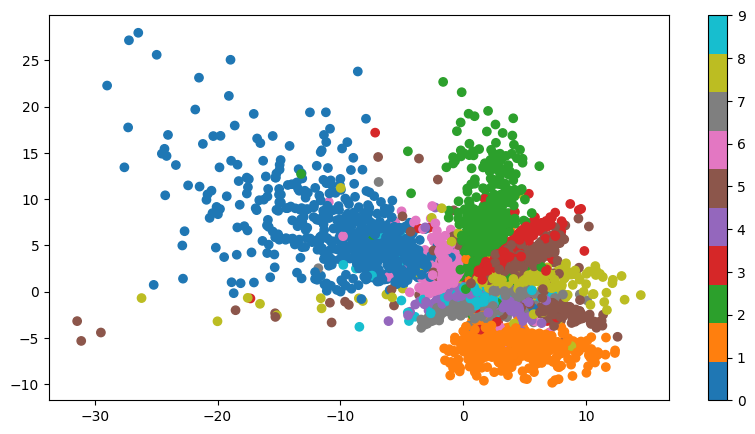

In [154]:
plot_latent(valLoader, encoder)

Agora, vamos fazer early stopping considerando o erro de validação. Setamos o número de iterações para 20, conforme fizemos no caso anterior, mas permitimos que o treinamento seja interrompido com o early stopping.

In [161]:
criterion = nn.MSELoss()

encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)

# train the model
epochs = 20
best_loss = np.inf

for epoch in range(epochs):
    for i, (images, _) in enumerate(trainLoader):
        images = images.view(-1, 28 * 28).to(device)

        # forward pass
        encoded = encoder(images)
        decoded = decoder(encoded)

        # compute loss
        loss = criterion(decoded, images)

        # backward pass
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        loss.backward()

        # update parameters
        encoder_optimizer.step()
        decoder_optimizer.step()

    # get validation loss
    val_loss = get_val_loss(valLoader, encoder, decoder, criterion)

    # does early stopping
    if val_loss < best_loss:
        best_loss = val_loss
    else:
        break

# print the epoch when the training stopped
print("Stopped at epoch {epoch} - Loss: {loss}".format(epoch = epoch + 1, loss = loss.item()))

Stopped at epoch 5 - Loss: 0.030932605266571045


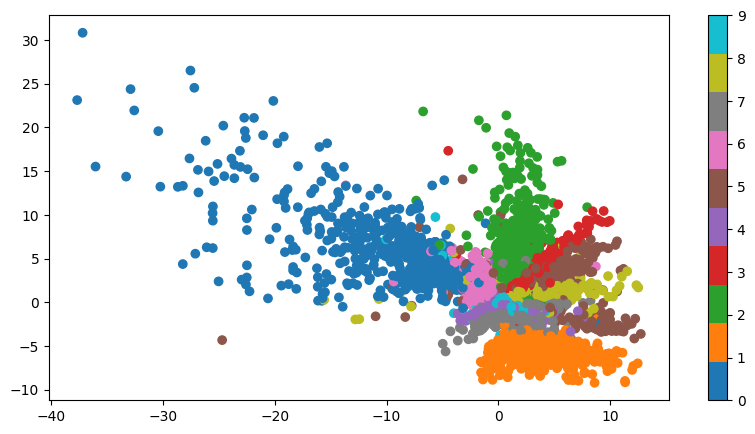

In [162]:
plot_latent(testLoader, encoder)

Na prática, observe que obtivemos um resultado bastante semelhante ao caso anterior, mostrando que o early stopping foi efetivo. Na prática, mesmo iterando apenas 5 vezes, já obtemos um resultado bastante satisfatório.

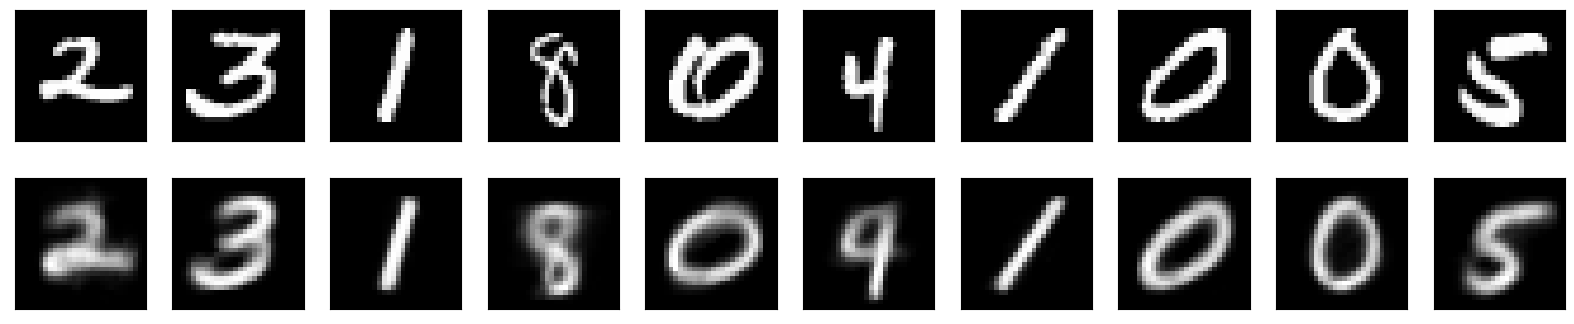

In [163]:
# test the model
with torch.no_grad():
    for images, _ in testLoader:
        images = images.view(-1, 28 * 28).to(device)
        encoded = encoder(images)
        decoded = decoder(encoded)
        break

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i].cpu().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded[i].cpu().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

---

## **Anotações**

### Problem setting --- **Principal Component Analysis (PCA)**

Queremos uma projeção para os dados de entrada em um espaço de menor dimensão, de forma que a informação relevante seja preservada. Os dados projetados são essencialmente combinações lineares dos dados originais e capturam a maior variância possível. 

Há várias formas de se fazer Principal Component Analysis, e implementaremos a eigen-decomposition da matriz de covariância dos dados.